<a href="https://colab.research.google.com/github/fabienfrfr/ComputerVisionAnimation/blob/main/notebook_computer-vision_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comment un réseau de neurone comprend une image ?

Les ordinateurs pilotent les voitures, battent les meilleurs joueurs aux échecs et détectent les cancers... Comment ? Grâce aux réseaux de neurones ! Le cerveau humain contient plus de 80 milliards de neurones et l'idée est d'imiter cette structure pour permettre à une machine de résoudre des problèmes difficiles.

Dans ce notebook, nous verrons un exemple "complet" d'un réseau de neurone qui peut résoudre un problème d'Annotation automatique d'images (*Image annotation captionning* en anglais). Une grosse partie du code et du modèle d'entrainement sont inspirés du code de [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) et [Subangkar](https://github.com/Subangkar/Image-Captioning-Attention-PyTorch). L'objectif ici n'est pas d'entrainer des réseaux de neurones compliqués, dans notre cas, nous utilisons un modèle déjà pré-entrainé.

Pour commencer, nous verrons un petit aperçu mathématique des réseaux de neurone. Vous pouvez passer directement dans la partie suivante si vous êtes déjà connaisseur, si c'est le contraire, je ne peux que vous conseiller le livre [DEEPMATH](https://exo7math.github.io/deepmath-exo7/) d'*Arnaud Bodin* et *François Recher* pour approfondir encore plus.

---

**Sommaire :**

- [***1-Overview***](#phase1)
 - Théorème d'approximation universel
 - Algorithme de descente de gradient
 - Convolution --> Resnet
 - Recurrence --> LSTM
 - Transformer --> Attention
- [***2-Modelization***](#phase2)
 - Schéma
 - Code
- [***3-Animation***](#phase3)
 - Opération sur une image
 - Code
- [***4-Conclusion & Opening***](#phase4)
 - YOLO
 - NEAT
 - GNN

---

## 1 - Apercu (work in progress)
<a id='phase1'></a>

Le principe d'un neurone artificiel, ou "perceptron linéaire" est de prendre des valeurs en entrées, de faire un calcul simple et de renvoyer une valeur en sortie. Les calculs dépendent de paramètres propres à chaque perceptron.

$$ o= f(z) = \left\{\begin{matrix} 1 & \mathrm{si} & \sum_{i=1}^n w_i x_i > \theta \\ 0 & \mathrm{sinon} & \end{matrix}\right. $$

Un neurone seul ne peut représenter seulement des fonctions logiques monotones (ET, OU et NON). Mais lorsqu'on les combinents, ont peut calculer n'importe quelle fonction logique non monotone, ou ensemble réalisable. Mais le plus important, c'est qu'avec un monocouche de taille infini, connecté à un seul neurone, on peut approximer n'importe quel fonction à une dimension, c'est le théorème d'approximation universel.

### Théorème d'approximation universel :

*Toute fonction continue $f : [a,b] \to \mathbb{R}$ peut être approchée uniformément par une fonction $F : [a,b] \to \mathbb{R}$ réalisée par un réseau de neurones.*

Voici un exemple avec un créneau de hauteur $4$ sur $[2,3]$ et un créneau de hauteur $6$ sur $[5,10]$.

<table><tr>
<td> <img src="figures/fig_neurones_85.png" style="width: 300;"/> </td>
<td> <img src="figures/fig_neurones_86.png" style="width: 300;"/> </td>
</tr></table>

La preuve de ce théorème se rapproche de la construction de l'intégrale. Pour calculer l'intégrale, on calcule en fait l'aire de rectangles. Ces rectangles correspondent à nos fonctions en escalier. 

### Algorithme de descente de gradient :

Toute la difficulté réside dans la recherche des poids des neurones pour approcher une fonction de sortie. On exploite les propriétés de l'opérateur différentiel et la règle de la chaine (dérivé composé). Pour cela on utilise la dérivé instantanné appliqué au réseau de neurone :

$$ \frac{\partial F}{\partial a} = (F \circ a)'(h,b) = \sum_{i=1}^{\ell} \frac{\partial h_i}{\partial a} \cdot \frac{\partial b_i}{\partial h_i} \cdot \frac{\partial F}{\partial b_i} = \sum_{i=1}^{\ell} f_* \cdot \frac{g'_*}{g_*} \cdot b_{i} \cdot \frac{\partial F}{\partial b_i} $$

![grad](figures/fig-gradres-03.png)

À partir de cette formule, l'idée est de calculer la différence entre la fonction voulu et la sortie du reseau, on parle aussi de la retropropagration du gradient de l'erreur, où plus communément "descente de gradient". Pour que la recherche de l'optimum soit plus efficasse et ne bloque pas sur un minimum local, on y ajoute un terme d'acceleration (voir Adam).

$$P_{k+1} = P_k + \mu\overrightarrow{P_{k-1}P_k}  - \delta \mathit{grad  } f(P_k).$$

![dg](figures/fig_moment04.png)

Un autre moyen est de perturber la sortie (crop, transformation, noise), de bloquer certain poids du reseau pendant un cycle d'entrainement (dropout) ou encore de tester differente métrique (Dice, RMS, etc.). Evite : surrapprentissage et permet généralisation.


### Réseau convolutionnel :

Néamoins, le calcul des poids des neurones demande beaucoup de ressource de calcul et parfois, les données en entrée ont des informations locales. Pour résoudre ce probleme, on a inventé les neurones de convolution. La convolution est la généralisation de la moyenne glissante et est tres utilisé dans la théorie des signaux (exemple : detection bords). Dans le cas le plus simple, on peut decrire n'importe quel systeme linéaire comme le produit de convolution d'un filtre (fonction de transfert) et une entrée. 

![conv](figures/Convolucion_Funcion_Pi.gif)

Un neurone de convolution est l'equivalent du produit de convolution. L'objectif de l'apprentissage est de trouver les poids du motifs de convolution. Le nombre de poids à calculer est beaucoup plus réduit car ils se partage plusieurs fois les elements de l'image. Pour chaque couche, on a plusieurs neurones de convolution, de facons à extraire des caractéristiques differentes.

![cnn](figures/fig-convolution1d-08.png)

Dans le cas où l'on a beaucoup de caractéristique de calcul, le reseau devient tres profond et l'algorithme de descente de gradient remonte mal les poids vers le début du réseau. Pour contourné ce probleme, il existe des reseau de neurone résiduel (ResNet) qui saute plusieurs caractéristique pendant l'entrainement, ce qui permet de ne pas trop attenuer les reseaux profonds. 

### Réseau récurrent :

Le cas des reseaux récurrent est tres employé lorsqu'on a un problème où l'on veut garder en mémoire de l'information à des temps $t-n$, comme par exemple, les données de language naturels (NLP). Dans ce cas, les reseaux sont par construction temporelle, meme s'il n'y a qu'une seule couche.

![rnn](figures/path45824-06.png)

Les phénomènes de gradient qui disparait et qui explose (en anglais vanishing gradient et exploding gradient) sont souvent rencontrés dans le contexte des RNNs. Ceci est dû au fait qu'il est difficile de capturer des dépendances à long terme à cause du gradient multiplicatif qui peut décroître/croître de manière exponentielle en fonction du nombre de couches.

Les unités de porte récurrente (en anglais Gated Recurrent Unit) (GRU) et les unités de mémoire à long/court terme (en anglais Long Short-Term Memory units) (LSTM) apaisent le problème du gradient qui disparait rencontré par les RNNs traditionnels, où le LSTM peut être vu comme étant une généralisation du GRU. Concretement, la fonction d'activation du neurone contient des parametres supplementaire que le biais et les poids.


### Transformer :

Le modèle d'attention (en anglais attention model) permet au RNN de mettre en valeur des parties spécifiques de l'entrée qui peuvent être considérées comme étant importantes, ce qui améliore la performance du modèle final en pratique. En notant $\alpha^{< t, t'>} α^{<t,t′>}$  la quantité d'attention que la sortie $y^{< t >} y <t>$ devrait porter à l'activation $a^{< t' >} a <t ′>$ et au contexte $c^{< t >}c <t>$ à l'instant $tt$, on a :

La quantité d'attention que la sortie $y^{< t >}y <t>$ devrait porter à l'activation $a^{< t' >}a <t ′ >$ est donné $\alpha^{< t,t' >}α <t,t ′ >$ , qui est calculé de la manière suivante :

### Synthèse

Voir le Cheat Sheet "CS 229 ― Machine Learning" des jumeaux *Afshine Amidi* et *Shervine Amidi* ici : https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning. Très bien réalisé et dépasse les explications avec les mains vue ici.

---

## 2 - Modélisation
<a id='phase2'></a>

Le modele est largement inspiré du modele de [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning). On a 3 partie : 

- **Encoder** : L'encodeur encode l'image d'entrée avec 3 canaux de couleur en une image plus petite avec des canaux « appris ». Cette image encodée plus petite est une représentation sommaire de tout ce qui est utile dans l'image originale. Puisque nous voulons encoder des images, nous utilisons des réseaux de neurones convolutifs (CNN). Nous n'avons pas besoin de former un encodeur à partir de zéro. Pourquoi? Parce qu'il existe déjà des CNN formés pour représenter des images. Pendant des années, les gens ont construit des modèles qui sont extraordinairement bons pour classer une image dans l'une des mille catégories. Il va de soi que ces modèles capturent très bien l'essence d'une image. J'ai choisi d'utiliser le réseau résiduel à 101 couches formé sur la tâche de classification ImageNet, déjà disponible dans PyTorch. Comme indiqué précédemment, il s'agit d'un exemple d'apprentissage par transfert. Vous avez la possibilité de l'ajuster pour améliorer les performances.

- **Decoder** : Le travail du décodeur est de regarder l'image encodée et de générer une légende mot par mot. Puisqu'il génère une séquence, il faudrait qu'il s'agisse d'un réseau neuronal récurrent (RNN). Nous utiliserons un LSTM. Dans un réglage typique sans attention, vous pouvez simplement faire la moyenne de l'image encodée sur tous les pixels. Vous pouvez ensuite l'alimenter, avec ou sans transformation linéaire, dans le décodeur comme premier état caché et générer la légende. Chaque mot prédit est utilisé pour générer le mot suivant.

- **Attention** : Le réseau Attention calcule ces poids. Intuitivement, comment estimeriez-vous l'importance d'une certaine partie d'une image ? Vous devez être conscient de la séquence que vous avez générée jusqu'à présent, afin de pouvoir regarder l'image et décider de ce qui doit être décrit ensuite. Par exemple, après avoir mentionné un homme, il est logique de déclarer qu'il tient un ballon de football. C'est exactement ce que fait le mécanisme Attention - il considère la séquence générée jusqu'à présent et s'occupe de la partie de l'image qui doit être décrite ensuite.

![model](figures/model.png)

Pour évaluer les performances du modèle sur l'ensemble de validation, il a été utilisé la métrique d'évaluation automatisée BiLingual Evaluation Understudy (BLEU). Cela évalue une légende générée par rapport à une ou plusieurs légendes de référence.

Le code du modèle et de l'entrainement n'a pas été fait par moi-même, si vous souhaitez voir sont fonctionnement, vous pouvez aussi faire du retro-ingeniering du code. Quelque tips sur ipython3 pour etre en mode debug, avec un checkpoint à la ligne 42 :

```
[ipython] run -d -b42 filename.py

```

Reload packages automatiquement (en cas de modification)

In [1]:
%load_ext autoreload
%autoreload 2

Package import

In [3]:
import os,cv2, torch, pickle, itertools
import numpy as np, pylab as plt

/home/fabienfrfr/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing pretrained models (passage en mode évaluation)

In [20]:
from models_import import caption_model, process_caption
from utils_math import CenterCropping
from utils_animate import show_all_channel, construct_arrayAnimation, animate_2dArray

In [ ]:
## Path
MODEL_DIR = 'saved_models/resnet101_attention-embed_lstm/'
MODEL_NAME = 'resnet101_attention-embed_lstm_best-train.pt'
INPUT_DIR = 'input/'
## import model
model, checkpoint, word2idx, idx2word = caption_model(MODEL_DIR,MODEL_NAME)

Image prediction inference (with hook)

[INFO] Starting System...
[INFO] Calculation type : cpu
[INFO] Importing vocabulary..
[INFO] Vocabulary parameter : (7707, 40)
[INFO] Importing pretrained model (Datasets : ImageNet for encoder, Flicker8k for decoder)..
[INFO] Importing pretrained success
[INFO] Importing torch model..
[INFO] Affect state in torch model..
[INFO] Switch models to inference mode..
[INFO] Torch model ready to use !
[INFO] Importing image "VECT_path1221.png" ..
[INFO] Prepare image for neural network model..
[INFO] Define checkpoint of intermediate result layer..
[INFO] Processing neural network model..
[INFO] Saving checkpoint..
[INFO] Processing done !
[INFO] Results : a person is standing on a sand dune . 


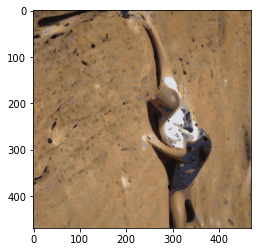

In [77]:
%matplotlib inline
## exemple
img_list = os.listdir(INPUT_DIR)
img_name = np.random.choice(img_list)
image_path = INPUT_DIR + img_name
print('[INFO] Importing image "'+img_name+'" ..')
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = CenterCropping(image) #Not necessary
print('[INFO] Prepare image for neural network model..')
im = torch.tensor(np.rollaxis(image, -1,0)/255., dtype=torch.float32)
## apply
encoder, decoder, caption_pred = process_caption(im, model, word2idx, idx2word)
print('[INFO] Results : ' + caption_pred)
plt.imshow(image); plt.show()

Intermediate encoder layers result

## 3 - Animation
<a id='phase3'></a>

OpenCV  propose la plupart des opérations classiques en traitement bas niveau des images :
- lecture, écriture et affichage d’une image ;
- calcul de l'histogramme des niveaux de gris ou d'histogrammes couleurs ;
- lissage, filtrage ;
- seuillage d'image (méthode d'Otsu, seuillage adaptatif)
- segmentation (composantes connexes, GrabCut) ;
- morphologie mathématique.

In [53]:
show_all_channel(encoder)

[INFO] Layer : 0; Shape : ((64, 188, 188), (8, 8))
[INFO] Layer : 1; Shape : ((64, 188, 188), (8, 8))
[INFO] Layer : 2; Shape : ((64, 188, 188), (8, 8))
[INFO] Layer : 3; Shape : ((64, 94, 94), (8, 8))
[INFO] Layer : 4; Shape : ((256, 94, 94), (16, 16))
[INFO] Layer : 5; Shape : ((512, 47, 47), (32, 16))
[INFO] Layer : 6; Shape : ((1024, 24, 24), (32, 32))
[INFO] Layer : 7; Shape : ((2048, 12, 12), (64, 32))


In [54]:
animEncoder = construct_arrayAnimation(image, encoder, 0, custom_txt=['Encoder :   Layers: ',''])

[INFO] Transform input image..
[INFO] Extract best feature of layer : 0
[INFO] Extract best feature of layer : 1
[INFO] Extract best feature of layer : 2
[INFO] Extract best feature of layer : 3
[INFO] Extract best feature of layer : 4
[INFO] Extract best feature of layer : 5
[INFO] Extract best feature of layer : 6
[INFO] Extract best feature of layer : 7
[INFO] Feature extracted, ready for animation !


In [55]:
animDecoder = construct_arrayAnimation(image, decoder, 1, custom_txt=['Decoder :   < ',' >'], smooth=True, alpha = False)

[INFO] Transform input image..
[INFO] Extract Attention : 
[INFO] Feature extracted, ready for animation !


Animation Encoder & Decoder :

In [56]:
animArray = animEncoder + animDecoder

<IPython.core.display.Javascript object>


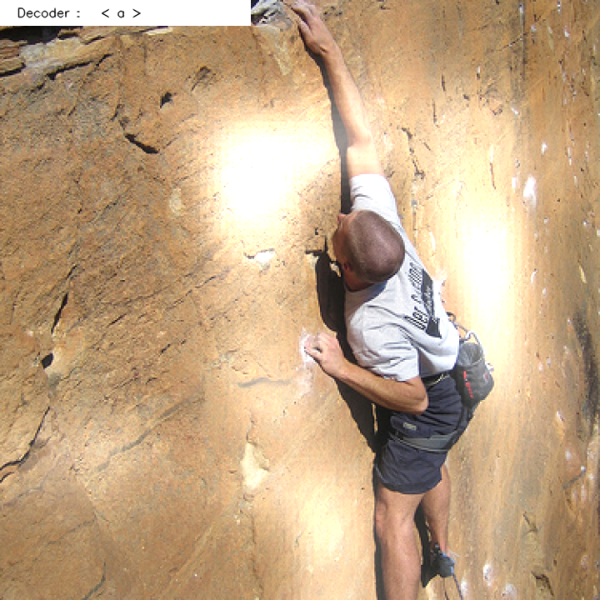

In [57]:
%matplotlib notebook

anim = animate_2dArray(animArray)
anim.animate()
plt.show()

## 4 - Conclusion
<a id='phase4'></a>

Les reseaux YOLO, NEAT et GNN pour un autre points de vue "classique".